In [ ]:
import pandas as pd
from os.path import join
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
sns.set_context('talk')
%matplotlib inline

In [ ]:
## SETTINGS
data_dir = '../../data/raw/temp_sensors/pre_experiment_final_calibration/'
means = {}

In [61]:
def make_plots_and_means(dfs,experiment_times,site_str,means=None,room_temp=True):
    if means==None:
        means = {}
        
    means[site_str] = {}
    n_ex = len(experiment_times)

    pretty_metrics = ['Temperature','RH']

    for mi,metric in enumerate(['temp','rh']):
        means[site_str][metric] = {}
        means[site_str][metric]['individ'] = {}
        means[site_str][metric]['room'] = {}

        fig,ax = plt.subplots(n_ex,2,figsize = (12,n_ex*6))

        for ei,e in enumerate(experiment_times):
            for gi,g in enumerate(['control','treatment']):
                if len(experiment_times) > 1:
                    this_ax = ax[ei,gi]
                    first_ax = ax[0,0]
                    second_ax = ax[0,1]
                    last_ax = ax[n_ex-1,1]
                else:
                    this_ax = ax[gi]
                    first_ax = ax[0]
                    second_ax = ax[1]
                    last_ax = second_ax
                if ei == 0:
                    means[site_str][metric]['individ'][g] = []
                    means[site_str][metric]['room'][g] = []

                for si in range(6):
                    data = dfs[g][si].loc[e[0]:e[1]]

                    # for all individual sensors
                    metric_df = data.iloc[:,mi+1]
                    means[site_str][metric]['individ'][g].append(metric_df.mean())
                    metric_df.name = 'Sensor {}'.format(si+1)
                    metric_df.plot(ax=this_ax)

                # for main room sensor
                if room_temp:
                    data = dfs[g][6].loc[e[0]:e[1]]
                    metric_df = data.iloc[:,mi]
                    means[site_str][metric]['room'][g].append(metric_df.mean())
                    metric_df.name = 'Room Temp Sensor 1'
                    metric_df.plot(ax=this_ax,style='--')
                    
                    if metric == 'temp':
                        metric_df = dfs[g][7].loc[e[0]:e[1]]
                        means[site_str][metric]['room'][g].append(metric_df.mean())
                        metric_df.name = 'Room Temp Sensor 2'
                        metric_df.plot(ax=this_ax,style=':')

        first_ax.set_title('Control')
        second_ax.set_title('Treatment')
        last_ax.legend(loc='lower right')

        fig.suptitle('{} Pilot {} Measurements, {} Sessions'.format(
            site_str.title(),pretty_metrics[mi],n_ex),fontsize=18)
        fig.tight_layout()
        fig.subplots_adjust(top=.95)
        fig.savefig('../../results/figures/pilot/pilot_{}s_{}.png'.format(metric,site_str))

        for g in ['control','treatment']:
            means[site_str][metric]['individ'][g] = np.array(means[site_str][metric]['individ'][g]).mean()
            means[site_str][metric]['room'][g] = np.array(means[site_str][metric]['room'][g]).mean()

    return means


In [17]:
times = [(pd.to_datetime('20170924T1800'),pd.to_datetime('20170925T0730'))]

In [19]:
## Load DFs
dfs = {'treatment':[],
      'control':[]}
for gi,g in enumerate(['control','treatment']):
    for si in range(1,7):
        dfs[g].append(
            pd.read_csv(join(data_dir,'{}_{}.csv'.format(g,si)),
                        skiprows=1,index_col = 1, parse_dates = True))
    dfs[g].append(
        pd.read_excel(join(data_dir,'{}_room1.xls'.format(g)),
                      sheetname='Records',parse_dates=True,index_col=0))
    dfs[g].append(
        pd.read_excel(join(data_dir,'{}_room2.xls'.format(g)),
                      sheetname='Data Table',parse_dates=True,index_col=1,header=21).iloc[:,1])    

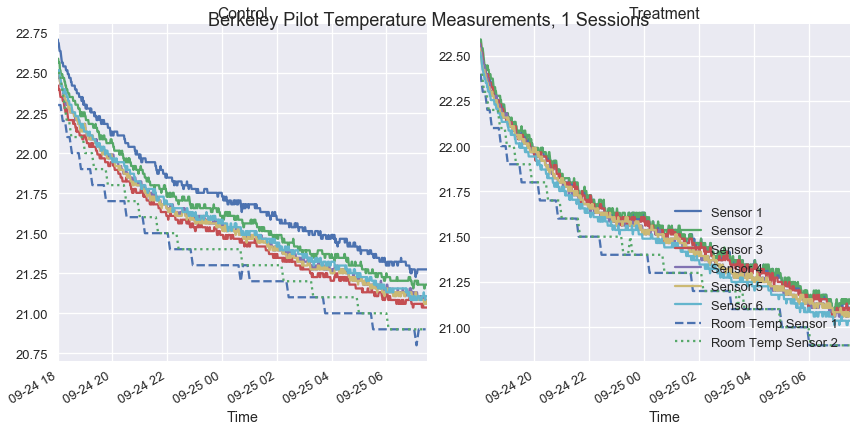

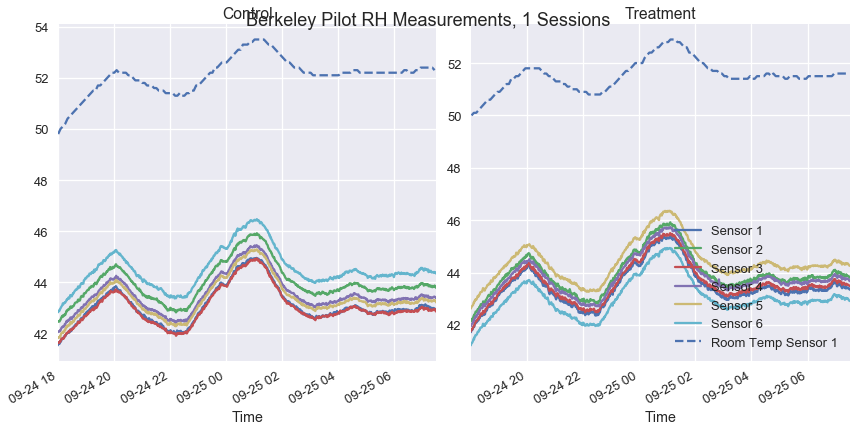

In [62]:
means = make_plots_and_means(dfs,times,'berkeley',room_temp=True)

In [64]:
means = {}
means['temp'] = {}
means['rh'] = {}

e = times[0]
for mi,m in enumerate(['temp','rh']):
    means[m]['hobo'] = 0
    for g in ['treatment','control']:
        for i in range(6):
            data = dfs[g][i].loc[e[0]:e[1]]
            metric_df = data.iloc[:,mi+1]
            means[m]['hobo'] += metric_df.mean()/12
            
        data = dfs[g][6].loc[e[0]:e[1]]
        metric_df = data.iloc[:,mi]
        means[m]['inkbird_{}'.format(g)] = metric_df.mean()
        
        if m == 'temp':
            metric_df = dfs[g][7].loc[e[0]:e[1]]
            means[m]['elitech_{}'.format(g)] = metric_df.mean()

In [66]:
means

{'rh': {'hobo': 43.653355724401635,
  'inkbird_control': 52.09629629629627,
  'inkbird_treatment': 51.53333333333332},
 'temp': {'elitech_control': 21.391975308641975,
  'elitech_treatment': 21.391358024691346,
  'hobo': 21.57020196196337,
  'inkbird_control': 21.314814814814817,
  'inkbird_treatment': 21.367283950617274}}

In [ ]:
hobo_mean = means['berkeley']['control']

## All means

In [ ]:
means_dicts = {}
mean_dict = means['berkeley']
means_berk_room = {'temp_control':mean_dict['temp']['room']['control'],
                   'temp_treatment':mean_dict['temp']['room']['treatment'],
                   'rh_control':mean_dict['rh']['room']['control'],
                   'rh_treatment':mean_dict['rh']['room']['treatment']}
means_berk_indiv = {'temp_control':mean_dict['temp']['individ']['control'],
                   'temp_treatment':mean_dict['temp']['individ']['treatment'],
                   'rh_control':mean_dict['rh']['individ']['control'],
                   'rh_treatment':mean_dict['rh']['individ']['treatment']}
mean_dict = means['busara']
means_bus_room = {'temp_control':mean_dict['temp']['individ']['control'],
                   'temp_treatment':mean_dict['temp']['individ']['treatment'],
                   'rh_control':mean_dict['rh']['individ']['control'],
                   'rh_treatment':mean_dict['rh']['individ']['treatment']}

pd.DataFrame({'Berkeley Room Temp':means_berk_room,
             'Berkeley Individual Sensors':means_berk_indiv,
             'Busara Individual Sensors':means_bus_room}).T